# Preprocessing and cleaning of the data part 3


In [376]:
import pandas as pd
import missingno as msno

In [377]:
data = pd.read_csv("data/data.csv")

In [378]:
def column_label_to_index(col_label):
    col_index = 0
    for c in col_label.upper():
        col_index = col_index * 26 + (ord(c) - ord('A') + 1)
    return col_index - 1


def add_prefix_to_first_row(dataframe, prefix, start_col_label, end_col_label):
    start_col = column_label_to_index(start_col_label)
    end_col = column_label_to_index(end_col_label)
    for col in range(start_col, end_col + 1):
        dataframe.iat[0, col] = prefix + dataframe.iat[0, col]

In [379]:
add_prefix_to_first_row(data, 'PESSOA_PIPEDRIVE_', 'A', 'R')
add_prefix_to_first_row(data, 'FUNIL_ASSINATURA_PIPEDRIVE_', 'S', 'X')
add_prefix_to_first_row(data, 'FUNIL_ONBOARDING_PIPEDRIVE_', 'Y', 'AH')
add_prefix_to_first_row(data, 'ATENDIMENTOS_AGENDA_', 'AI', 'AU')
add_prefix_to_first_row(data, 'WHOQOL_', 'AV', 'AZ')
add_prefix_to_first_row(data, 'COMUNICARE_', 'BA', 'BA')
add_prefix_to_first_row(data, 'TWILIO_', 'BB', 'BI')
add_prefix_to_first_row(data, 'COBRANÇA_VINDI_', 'BJ', 'BQ')

In [380]:
data.columns = data.iloc[0]
data = data.drop(data.index[0])

In [381]:
data = data.drop(["PESSOA_PIPEDRIVE_id_person_recommendation","PESSOA_PIPEDRIVE_Recebe Comunicados?", "PESSOA_PIPEDRIVE_Interesses", "PESSOA_PIPEDRIVE_Pontos de Atenção", "FUNIL_ONBOARDING_PIPEDRIVE_id_label"], axis=1)

<AxesSubplot:xlabel='0'>

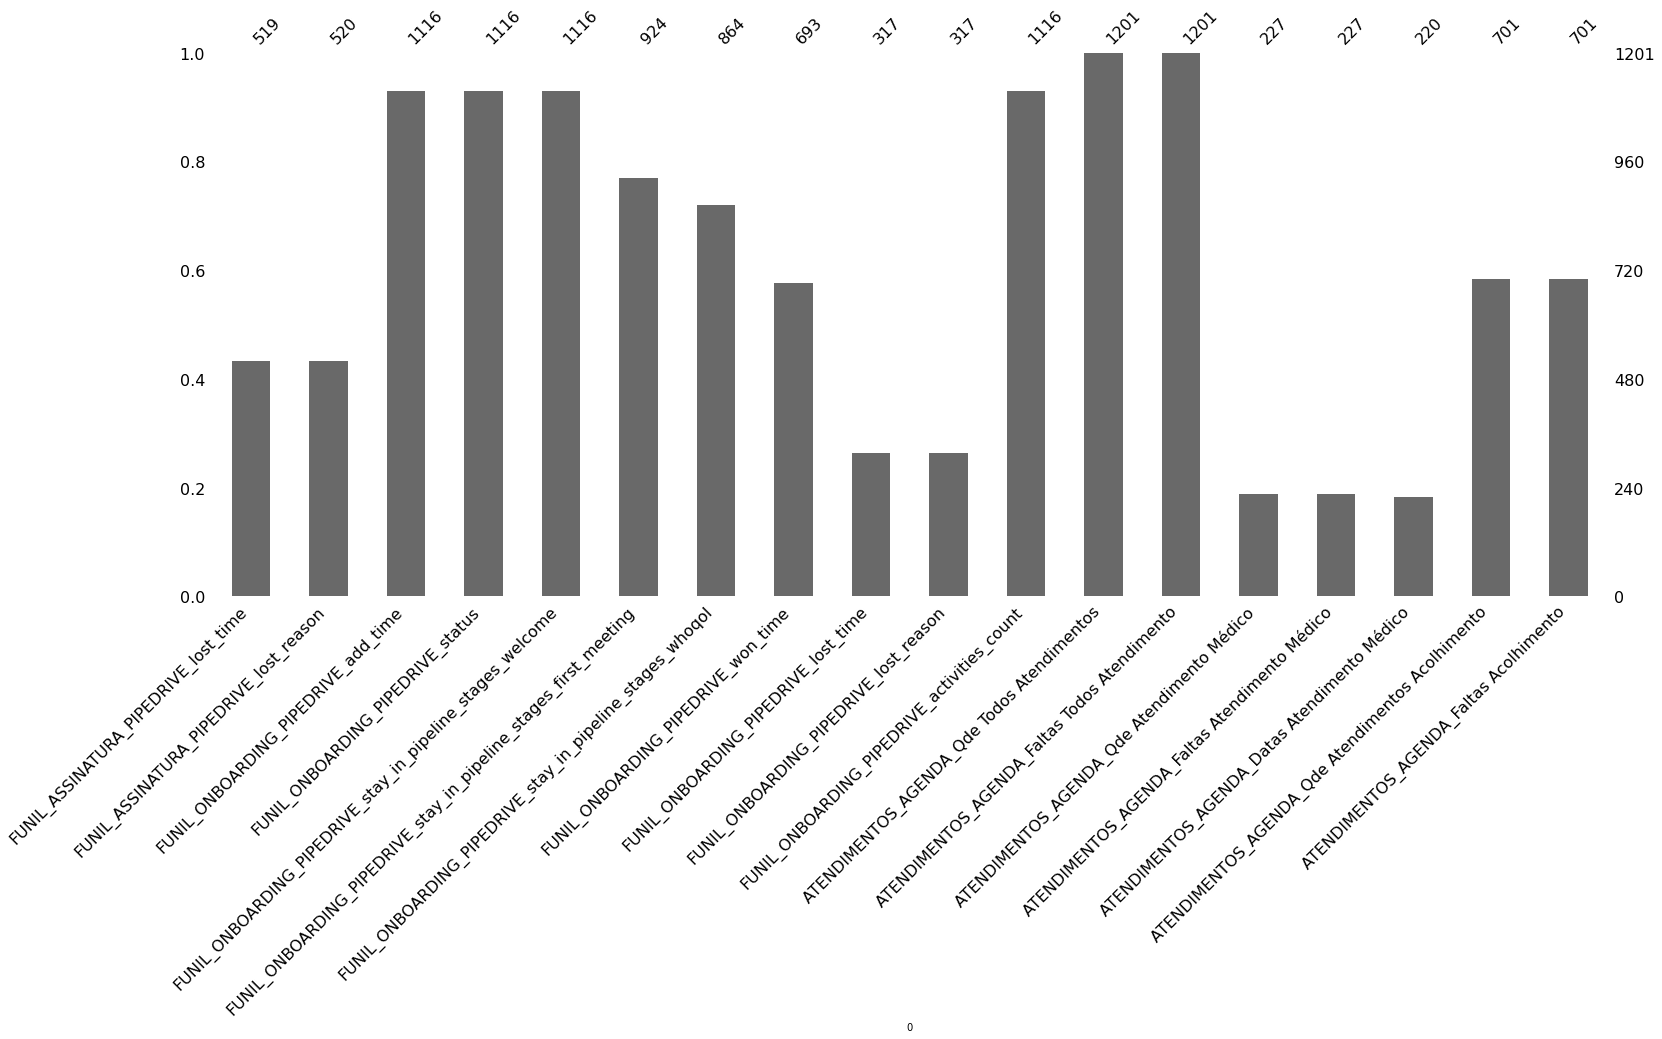

In [382]:
msno.bar(data.iloc[:,18:36])

## FUNIL_ASSINATURA_PIPEDRIVE_lost_time 

In [383]:
data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: FUNIL_ASSINATURA_PIPEDRIVE_lost_time, Length: 1201, dtype: object

Se existe algum contrato finalizado com lost time = null, insere a data de fim do contrato. Para o restante, substitui "null" por "em aberto", pois significa que o contrato ainda está em andamento. Quando há mais de uma data, pega a primeira data e normaliza todos para o modelo YYYY-MM-DD


In [384]:
import pandas as pd
from datetime import *

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
  if pd.notna(valor) == False: 
    if pd.notna(data.loc[indice, "PESSOA_PIPEDRIVE_contract_end_date"]):
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] =  data.loc[indice, "PESSOA_PIPEDRIVE_contract_end_date"]
    else:
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] = "Em aberto"

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
  if data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] != "Em aberto":
      index = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].find(";")
      if index != -1:
        data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"][:index]

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
  if data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] != "Em aberto":
    tamanho = len(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"])
    if tamanho > 10:
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"][:10]	

## Coluna extra: Tempo de permanência

Coluna criada para calcular tempo total do usuário na plataforma. Utiliza lost_time - start_of_service ou lost_time - contract_start_date, se os dados de start_of_service forem nulos.

In [385]:
import pandas as pd
from datetime import datetime

tempo_permanencia = []

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"].items():
  if pd.notna(valor):
      index = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"].find(";")
      if index != -1:
        data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"][:index]

for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_time"].items():
  if pd.notna(valor):
    if data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"] != "Em aberto":	
      if pd.notna(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"]):
        tempo_1 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"], '%Y-%m-%d')
        tempo_2 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_start_of_service"], '%Y-%m-%d')
        tempo_permanencia.append(str(tempo_1 - tempo_2))
      else:
        tempo_1 = datetime.strptime(data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_time"], '%Y-%m-%d')
        tempo_2 = datetime.strptime(data.loc[indice, "PESSOA_PIPEDRIVE_contract_start_date"], '%Y-%m-%d')
        tempo_permanencia.append(str(tempo_1 - tempo_2))
    else:
      tempo_permanencia.append("Em aberto")

data['stay_time'] = tempo_permanencia

for indice, valor in data["stay_time"].items():
  if valor != "Em aberto":
    index = data.loc[indice, "stay_time"].find(",")
    if index != -1:
      data.loc[indice, "stay_time"] = data.loc[indice, "stay_time"][:index]
    
#data["stay_time"].to_csv('data/data2q.csv', sep=';', index=False)

## FUNIL_ASSINATURA_PIPEDRIVE_lost_reason

Estando com multiplos motivos, manter o que aparece em primeiro lugar para facilitar a análise. Agrupa os que aparecem menos em um grupo "Outro" e classifica os nulos como "Assinatura ativa"


In [386]:
data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: FUNIL_ASSINATURA_PIPEDRIVE_lost_reason, Length: 1201, dtype: object

In [387]:
for indice, valor in data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].items():
  if pd.notna(valor):  
    index = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].find(";")
    if index != -1: 
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"] = data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"][:index]
  else:
      data.loc[indice, "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"] = "Assinatura ativa"
    
contagem = data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].value_counts()

agrupamento = contagem[contagem < 20].index
data.loc[data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].isin(agrupamento), "FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"] = "Outro"
frequencias = data["FUNIL_ASSINATURA_PIPEDRIVE_lost_reason"].value_counts()

print(frequencias)

Assinatura ativa                                              681
[Assinatura] Desligamento                                     257
Outro                                                          66
[Assinatura] Não quer seguir com a Ana                         59
[Assinatura] Empresa cancelou o benefício da Ana               59
[Assinatura] Precisou cortar custos                            30
[Assinatura] Cancelamento por inadimplência                    29
[Assinatura] Está sem tempo para conciliar os atendimentos     20
Name: FUNIL_ASSINATURA_PIPEDRIVE_lost_reason, dtype: int64


## FUNIL_ONBOARDING_PIPEDRIVE_add_time

In [388]:
data["FUNIL_ONBOARDING_PIPEDRIVE_add_time"]

1       2021-09-16 18:14:49
2       2021-09-16 18:15:46
3                       NaN
4                       NaN
5                       NaN
               ...         
1197    2023-11-07 12:22:13
1198    2023-11-07 13:05:44
1199    2023-11-07 14:34:25
1200    2023-11-07 20:34:02
1201    2023-11-08 19:03:40
Name: FUNIL_ONBOARDING_PIPEDRIVE_add_time, Length: 1201, dtype: object

Valores nulos preenchidos como "não iniciado". Demais colunas de onboarding sempre apresentam valores nulos quando esse campo é nulo, portanto, faz sentido que o processo não tenha sido iniciado.

In [389]:
data['FUNIL_ONBOARDING_PIPEDRIVE_add_time'].fillna('Não iniciado', inplace=True)
print(data['FUNIL_ONBOARDING_PIPEDRIVE_add_time'])

1       2021-09-16 18:14:49
2       2021-09-16 18:15:46
3              Não iniciado
4              Não iniciado
5              Não iniciado
               ...         
1197    2023-11-07 12:22:13
1198    2023-11-07 13:05:44
1199    2023-11-07 14:34:25
1200    2023-11-07 20:34:02
1201    2023-11-08 19:03:40
Name: FUNIL_ONBOARDING_PIPEDRIVE_add_time, Length: 1201, dtype: object


## FUNIL_ONBOARDING_PIPEDRIVE_status 

Substitui valores faltantes por "não iniciado". Valores faltantes aqui ocorrem quando na coluna "add_time" o valor é nulo

In [390]:
data["FUNIL_ONBOARDING_PIPEDRIVE_status"]

1        won
2       lost
3        NaN
4        NaN
5        NaN
        ... 
1197    open
1198    open
1199    open
1200    open
1201    open
Name: FUNIL_ONBOARDING_PIPEDRIVE_status, Length: 1201, dtype: object

In [391]:
data["FUNIL_ONBOARDING_PIPEDRIVE_status"].fillna("Não iniciado", inplace=True)
print(data["FUNIL_ONBOARDING_PIPEDRIVE_status"])

1                won
2               lost
3       Não iniciado
4       Não iniciado
5       Não iniciado
            ...     
1197            open
1198            open
1199            open
1200            open
1201            open
Name: FUNIL_ONBOARDING_PIPEDRIVE_status, Length: 1201, dtype: object


## Coluna extra: Último processo de onboarding concluído

Coluna criada usando as informações de stay_in_pipeline_stages_welcome, stay_in_pipeline_stages_first_meeting e stay_in_pipeline_stages_whoqol. Mostra o último processo concluído. 


In [392]:
ultimos_estados = []

for indice, valor in data["FUNIL_ONBOARDING_PIPEDRIVE_add_time"].items():
    if valor != "Não iniciado":
        if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_welcome"]):
            if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_first_meeting"]):
                if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_whoqol"]):
                    ultimos_estados.append("Questionário")
                else:
                    ultimos_estados.append("Primeira reunião")
            else:
                ultimos_estados.append("Boas-vindas")
        
    else:
        ultimos_estados.append("Não iniciado")

data["last_stage_concluded"] = ultimos_estados

data.drop(["FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_welcome", "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_first_meeting", "FUNIL_ONBOARDING_PIPEDRIVE_stay_in_pipeline_stages_whoqol"], axis=1, inplace=True)

## Coluna extra: duração de onboarding

Combina as informações de won_time e lost_time em uma única coluna. Se tiver lost time, usa lost time; se tiver won time, usa won time; se add time for null, usar "não iniciado"; do contrario, usar "em aberto".


In [393]:
tempo = []

for indice, valor in data["FUNIL_ONBOARDING_PIPEDRIVE_add_time"].items():
    if valor != "Não iniciado":
        if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_lost_time"]) == True:
            tempo.append(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_lost_time"])
        elif pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_won_time"]) == True:
            tempo.append(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_won_time"])
        else:
            tempo.append("Em aberto")
    else:
        tempo.append("Não iniciado")

data['process_time'] = tempo

#data["process_time"].to_csv('data/data2q.csv', sep=';', index=False)

data.drop(["FUNIL_ONBOARDING_PIPEDRIVE_won_time", "FUNIL_ONBOARDING_PIPEDRIVE_lost_time"], axis=1, inplace=True)



## FUNIL_ONBOARDING_PIPEDRIVE_activities_count

Trata valores nulos como 0, pois nenhuma atividade foi concluída.

In [394]:
data["FUNIL_ONBOARDING_PIPEDRIVE_activities_count"] = data["FUNIL_ONBOARDING_PIPEDRIVE_activities_count"].fillna(0)
data["FUNIL_ONBOARDING_PIPEDRIVE_activities_count"]

1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    1
1200    0
1201    0
Name: FUNIL_ONBOARDING_PIPEDRIVE_activities_count, Length: 1201, dtype: object

## FUNIL_ONBOARDING_PIPEDRIVE_lost_reason

Preenche valores nulos como "processo em aberto", "processo concluído" ou "processo não iniciado", de acordo com informações de outras colunas. Por fim, junta valores com menores frequências numa categoria "outros".

In [395]:
data["FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"]

1                       NaN
2       Cancelou assinatura
3                       NaN
4                       NaN
5                       NaN
               ...         
1197                    NaN
1198                    NaN
1199                    NaN
1200                    NaN
1201                    NaN
Name: FUNIL_ONBOARDING_PIPEDRIVE_lost_reason, Length: 1201, dtype: object

In [396]:
for indice, valor in data["FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"].items():
  if pd.notna(valor) == False:
    if pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_status"]) == False and pd.notna(data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_add_time"]):
      data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"] = "Processo em aberto"
    if data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_status"] == "won":
      data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"] = "Processo concluído"
    else:
      data.loc[indice, "FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"] = "Processo não iniciado"

data["FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"].to_csv('data/data2q.csv', sep=';', index=False)

contagem = data["FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"].value_counts()

agrupamento = contagem[contagem < 23].index
data.loc[data["FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"].isin(agrupamento), "FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"] = "Outro"
frequencias = data["FUNIL_ONBOARDING_PIPEDRIVE_lost_reason"].value_counts()

print(frequencias)

Processo concluído                                                   693
[Onboarding] Não retornou aos contatos de resgate                    222
Processo não iniciado                                                191
Outro                                                                 49
[Onboarding] Não tem interesse em seguir nas etapas do onboarding     23
[Associade] Cancelou assinatura                                       23
Name: FUNIL_ONBOARDING_PIPEDRIVE_lost_reason, dtype: int64


## Qde Todos Atendimentos

"Essas colunas onde há apenas FALSE em todos os campos, são dados em que não conseguimos pegar ainda de forma estruturada. Mas estamos tentando."


In [397]:
data["ATENDIMENTOS_AGENDA_Qde Todos Atendimentos"]

1       FALSE
2       FALSE
3       FALSE
4       FALSE
5       FALSE
        ...  
1197    FALSE
1198    FALSE
1199    FALSE
1200    FALSE
1201    FALSE
Name: ATENDIMENTOS_AGENDA_Qde Todos Atendimentos, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Faltas Todos Atendimento

"Essas colunas onde há apenas FALSE em todos os campos, são dados em que não conseguimos pegar ainda de forma estruturada. Mas estamos tentando."


In [398]:
data["ATENDIMENTOS_AGENDA_Faltas Todos Atendimento"]

1       FALSE
2       FALSE
3       FALSE
4       FALSE
5       FALSE
        ...  
1197    FALSE
1198    FALSE
1199    FALSE
1200    FALSE
1201    FALSE
Name: ATENDIMENTOS_AGENDA_Faltas Todos Atendimento, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Qde Atendimento Médico

Trata valores nulos como 0.

In [399]:
data["ATENDIMENTOS_AGENDA_Qde Atendimento Médico"]


1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Qde Atendimento Médico, Length: 1201, dtype: object

In [400]:

data["ATENDIMENTOS_AGENDA_Qde Atendimento Médico"] = data["ATENDIMENTOS_AGENDA_Qde Atendimento Médico"].fillna(0)
data["ATENDIMENTOS_AGENDA_Qde Atendimento Médico"]


1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    0
1200    0
1201    0
Name: ATENDIMENTOS_AGENDA_Qde Atendimento Médico, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Faltas Atendimento Médico

Trata valores nulos como 0.

In [401]:
data["ATENDIMENTOS_AGENDA_Faltas Atendimento Médico"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Faltas Atendimento Médico, Length: 1201, dtype: object

In [402]:

data["ATENDIMENTOS_AGENDA_Faltas Atendimento Médico"] = data["ATENDIMENTOS_AGENDA_Faltas Atendimento Médico"].fillna(0)
data["ATENDIMENTOS_AGENDA_Faltas Atendimento Médico"]

1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    0
1200    0
1201    0
Name: ATENDIMENTOS_AGENDA_Faltas Atendimento Médico, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Datas Atendimento Médico

Trata valores nulos como "nunca ocorreu".

In [403]:
data["ATENDIMENTOS_AGENDA_Datas Atendimento Médico"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Datas Atendimento Médico, Length: 1201, dtype: object

In [404]:
data["ATENDIMENTOS_AGENDA_Datas Atendimento Médico"] = data["ATENDIMENTOS_AGENDA_Datas Atendimento Médico"].fillna("Nunca ocorreu")
data["ATENDIMENTOS_AGENDA_Datas Atendimento Médico"]

1       Nunca ocorreu
2       Nunca ocorreu
3       Nunca ocorreu
4       Nunca ocorreu
5       Nunca ocorreu
            ...      
1197    Nunca ocorreu
1198    Nunca ocorreu
1199    Nunca ocorreu
1200    Nunca ocorreu
1201    Nunca ocorreu
Name: ATENDIMENTOS_AGENDA_Datas Atendimento Médico, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Qde Atendimentos Acolhimento

Preenche valores nulos com 0, indicando que nunca houve atendimento.

In [405]:
data["ATENDIMENTOS_AGENDA_Qde Atendimentos Acolhimento"]

1         1
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197      1
1198    NaN
1199    NaN
1200      2
1201    NaN
Name: ATENDIMENTOS_AGENDA_Qde Atendimentos Acolhimento, Length: 1201, dtype: object

In [406]:
data["ATENDIMENTOS_AGENDA_Qde Atendimentos Acolhimento"] = data["ATENDIMENTOS_AGENDA_Qde Atendimentos Acolhimento"].fillna(0)
data["ATENDIMENTOS_AGENDA_Qde Atendimentos Acolhimento"]

1       1
2       0
3       0
4       0
5       0
       ..
1197    1
1198    0
1199    0
1200    2
1201    0
Name: ATENDIMENTOS_AGENDA_Qde Atendimentos Acolhimento, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Faltas Acolhimento

Preenche valores nulos como 0, pois indicam que nunca foram marcadas consultas, então, também não houveram faltas.

In [407]:
data["ATENDIMENTOS_AGENDA_Faltas Acolhimento"]

1         0
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197      0
1198    NaN
1199    NaN
1200      0
1201    NaN
Name: ATENDIMENTOS_AGENDA_Faltas Acolhimento, Length: 1201, dtype: object

In [408]:
data["ATENDIMENTOS_AGENDA_Faltas Acolhimento"] = data["ATENDIMENTOS_AGENDA_Faltas Acolhimento"].fillna(0)
data["ATENDIMENTOS_AGENDA_Faltas Acolhimento"]

1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    0
1200    0
1201    0
Name: ATENDIMENTOS_AGENDA_Faltas Acolhimento, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Datas Acolhimento

Preenche valores nulos com "nunca ocorreu".

In [409]:
data["ATENDIMENTOS_AGENDA_Datas Acolhimento"]

1                            2022-04-29 18:00:00
2                                            NaN
3                                            NaN
4                                            NaN
5                                            NaN
                          ...                   
1197                         2023-11-07 12:30:00
1198                                         NaN
1199                                         NaN
1200    2023-11-14 18:00:00; 2023-11-22 18:30:00
1201                                         NaN
Name: ATENDIMENTOS_AGENDA_Datas Acolhimento, Length: 1201, dtype: object

In [410]:
data["ATENDIMENTOS_AGENDA_Datas Acolhimento"] = data["ATENDIMENTOS_AGENDA_Datas Acolhimento"].fillna("Nunca ocorreu")
data["ATENDIMENTOS_AGENDA_Datas Acolhimento"]

1                            2022-04-29 18:00:00
2                                  Nunca ocorreu
3                                  Nunca ocorreu
4                                  Nunca ocorreu
5                                  Nunca ocorreu
                          ...                   
1197                         2023-11-07 12:30:00
1198                               Nunca ocorreu
1199                               Nunca ocorreu
1200    2023-11-14 18:00:00; 2023-11-22 18:30:00
1201                               Nunca ocorreu
Name: ATENDIMENTOS_AGENDA_Datas Acolhimento, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Qde Psicoterapia

Preenche valores nulos com 0, pois indica que nunca ocorreram atendimentos.

In [411]:
data["ATENDIMENTOS_AGENDA_Qde Psicoterapia"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Qde Psicoterapia, Length: 1201, dtype: object

In [412]:
data["ATENDIMENTOS_AGENDA_Qde Psicoterapia"] = data["ATENDIMENTOS_AGENDA_Qde Psicoterapia"].fillna(0)
data["ATENDIMENTOS_AGENDA_Qde Psicoterapia"]

1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    0
1200    0
1201    0
Name: ATENDIMENTOS_AGENDA_Qde Psicoterapia, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Faltas Psicoterapia

Preenche valores nulos com 0, pois indica que nunca ocorreram faltas.

In [413]:
data["ATENDIMENTOS_AGENDA_Faltas Psicoterapia"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Faltas Psicoterapia, Length: 1201, dtype: object

In [414]:
data["ATENDIMENTOS_AGENDA_Faltas Psicoterapia"] = data["ATENDIMENTOS_AGENDA_Faltas Psicoterapia"].fillna(0)
data["ATENDIMENTOS_AGENDA_Faltas Psicoterapia"]

1       0
2       0
3       0
4       0
5       0
       ..
1197    0
1198    0
1199    0
1200    0
1201    0
Name: ATENDIMENTOS_AGENDA_Faltas Psicoterapia, Length: 1201, dtype: object

## ATENDIMENTOS_AGENDA_Datas Psicoterapia

Preenche os valores nulos com "Nunca ocorreu".

In [415]:
data["ATENDIMENTOS_AGENDA_Datas Psicoterapia"]

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
       ... 
1197    NaN
1198    NaN
1199    NaN
1200    NaN
1201    NaN
Name: ATENDIMENTOS_AGENDA_Datas Psicoterapia, Length: 1201, dtype: object

In [416]:
data["ATENDIMENTOS_AGENDA_Datas Psicoterapia"] = data["ATENDIMENTOS_AGENDA_Datas Psicoterapia"].fillna("Nunca ocorreu")
data["ATENDIMENTOS_AGENDA_Datas Psicoterapia"]

1       Nunca ocorreu
2       Nunca ocorreu
3       Nunca ocorreu
4       Nunca ocorreu
5       Nunca ocorreu
            ...      
1197    Nunca ocorreu
1198    Nunca ocorreu
1199    Nunca ocorreu
1200    Nunca ocorreu
1201    Nunca ocorreu
Name: ATENDIMENTOS_AGENDA_Datas Psicoterapia, Length: 1201, dtype: object

<AxesSubplot:xlabel='0'>

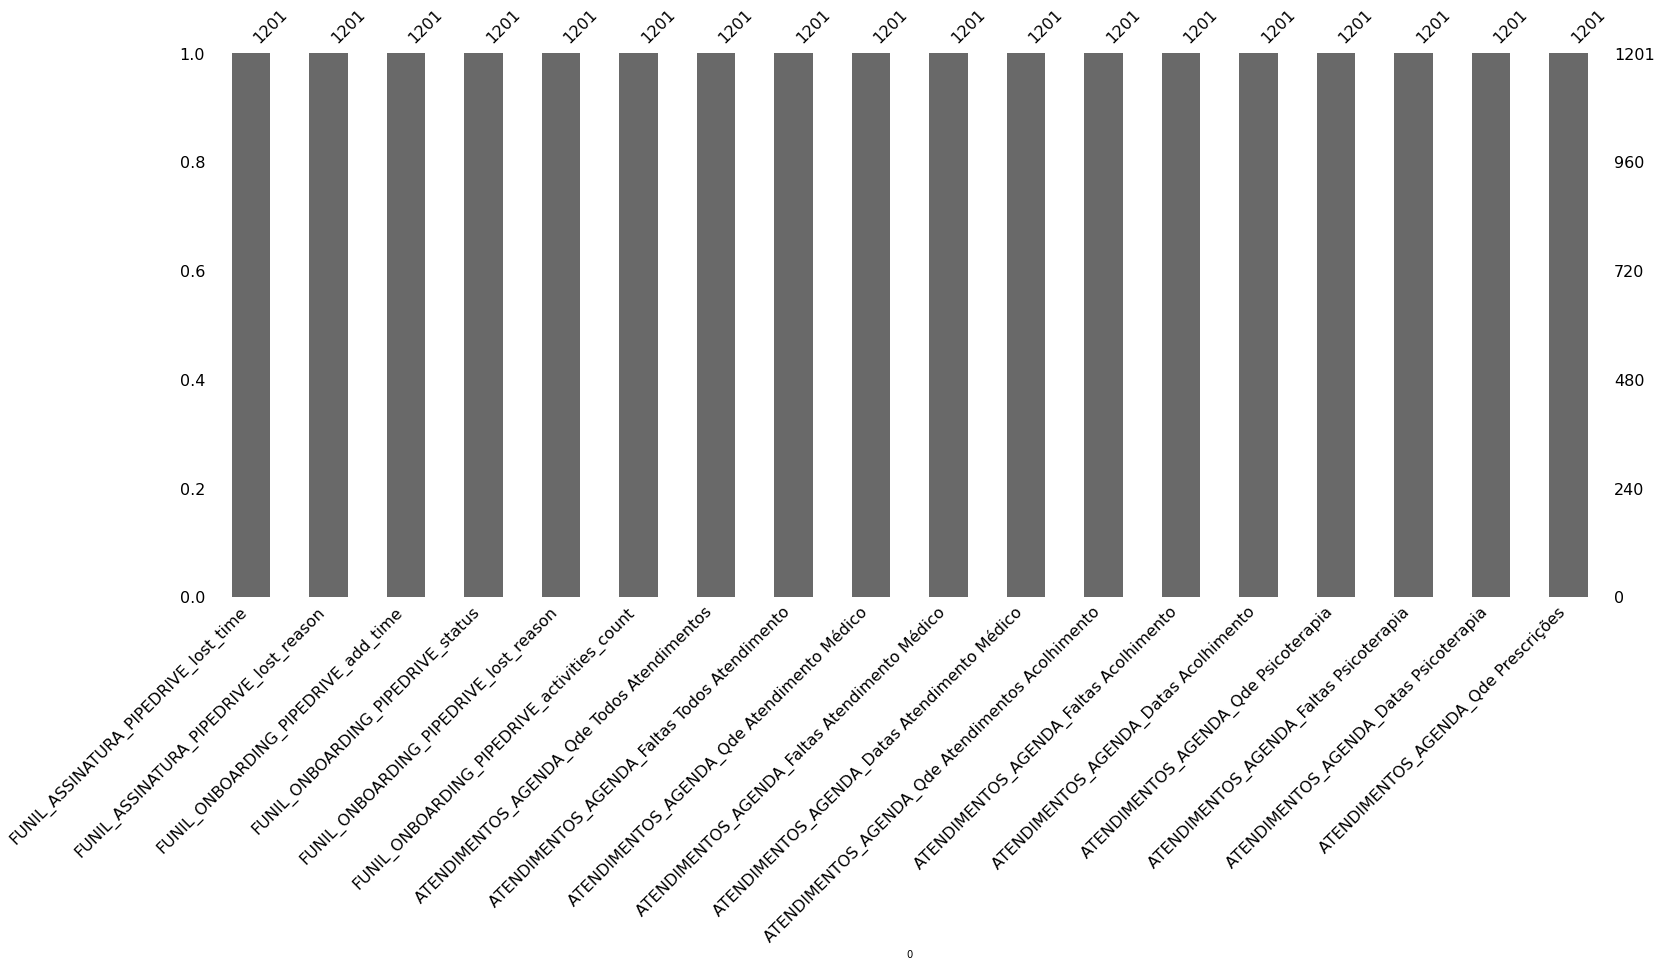

In [417]:
msno.bar(data.iloc[:,18:36])